# Hospital Readmission within 6 months Prediction

## Introduction

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

from src.visualisation import (plot_class_counts, plot_distributions, plot_binary_distributions, plot_pairplot, 
                                    plot_num_var_histograms, plot_boxplots, plot_outliers_per_subject, plot_outliers_per_feature)
from src.process import (remove_dead_patients, analyze_categorical_features, apply_pca, process_cat_variables,
                         process_binary_variables, check_nan_columns, drop_high_nan_columns, create_exam_feature, analyze_outliers, OutlierToNan, FeatureSelector)
from src.utils import load_data, split_and_save_dataset
from scipy.stats import zscore

%load_ext autoreload
%autoreload 2


In [96]:
from omegaconf import OmegaConf
from src.process import process

# Load config file directly
config = OmegaConf.load("../config/main.yaml")

# Call your pipeline
x_cat, x_bin, x_num = process(config)


Loading data using data/raw/data.csv
Number of rows and columns: (2008, 167)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008 entries, 0 to 2007
Columns: 167 entries, Unnamed: 0 to ageCat
dtypes: float64(119), int64(33), object(15)
memory usage: 2.6+ MB
None
       Unnamed: 0  inpatient.number  visit.times  body.temperature  \
count  2008.00000       2008.000000  2008.000000       2008.000000   
mean   1004.50000     797747.542829     1.092629         36.416484   
std     579.80399      41127.801740     0.365946          0.439529   
min       1.00000     722128.000000     1.000000         35.000000   
25%     502.75000     763164.500000     1.000000         36.200000   
50%    1004.50000     798758.000000     1.000000         36.300000   
75%    1506.25000     829399.750000     1.000000         36.500000   
max    2008.00000     905720.000000     5.000000         42.000000   

             pulse  respiration  systolic.blood.pressure  \
count  2008.000000  2008.000000             

In [97]:
x_cat

,DestinationDischarge,admission.ward,occupation,gender,type.of.heart.failure,NYHA.cardiac.function.classification,Killip.grade,outcome.during.hospitalization,ageCat
0,<NA>,Cardiology,UrbanResident,Male,Single,3,2,Alive,6
1,Home,Cardiology,UrbanResident,Female,Both,3,3,Alive,4
2,Home,Cardiology,NaN,Female,Both,3,2,Alive,6
3,Home,Cardiology,UrbanResident,Female,Both,3,1,Alive,7
4,Home,Cardiology,UrbanResident,Male,Both,4,2,Alive,6
...,...,...,...,...,...,...,...,...,...
1551,Home,Others,UrbanResident,Female,Single,3,1,Alive,6
1552,Home,Cardiology,NaN,Male,Both,3,1,Alive,3
1553,HealthcareFacility,Cardiology,UrbanResident,Female,Single,3,2,Alive,6
1554,Home,Cardiology,UrbanResident,Female,Both,3,1,Alive,6


### Import and Inspect data

In [2]:
df = load_data('data/raw/data.csv')

In [3]:
print("Number of patients:", df.shape[0])
print("Number of features:", df.shape[1])

# Check available features 
print(", \n".join(df.columns))

Number of patients: 2008
Number of features: 167
Unnamed: 0, 
inpatient.number, 
DestinationDischarge, 
admission.ward, 
admission.way, 
occupation, 
discharge.department, 
visit.times, 
gender, 
body.temperature, 
pulse, 
respiration, 
systolic.blood.pressure, 
diastolic.blood.pressure, 
map, 
weight, 
height, 
BMI, 
type.of.heart.failure, 
NYHA.cardiac.function.classification, 
Killip.grade, 
myocardial.infarction, 
congestive.heart.failure, 
peripheral.vascular.disease, 
cerebrovascular.disease, 
dementia, 
Chronic.obstructive.pulmonary.disease, 
connective.tissue.disease, 
peptic.ulcer.disease, 
diabetes, 
moderate.to.severe.chronic.kidney.disease, 
hemiplegia, 
leukemia, 
malignant.lymphoma, 
solid.tumor, 
liver.disease, 
AIDS, 
CCI.score, 
type.II.respiratory.failure, 
consciousness, 
eye.opening, 
verbal.response, 
movement, 
respiratory.support., 
oxygen.inhalation, 
fio2, 
acute.renal.failure, 
LVEF, 
left.ventricular.end.diastolic.diameter.LV, 
mitral.valve.EMS, 
mitral.valve

In [4]:
# Remove dead patients and related features in the dataset
df_no_dead = remove_dead_patients(df)

df_no_dead_future =df_no_dead.drop(['re.admission.within.3.months','re.admission.within.28.days','time.of.death..days.from.admission.',
                                    're.admission.time..days.from.admission.','return.to.emergency.department.within.6.months',
                                    'time.to.emergency.department.within.6.months'], axis=1)


Percentage of patients who died within 6 months: 0.00%

Removed features: death.within.6.months, death.within.3.months, death.within.28.days


Removing death-related features, which account for just 2.84% of the patient data, reduces bias by preventing data leakage. These features provide information about patients that would not be available at prediction time, such as outcomes directly tied to mortality. Including them could skew the model toward unrealistic patterns, such as associating death with no readmission, compromising its ability to generalize to living patients. By excluding these features and removing the small subset of deceased patients, the model can focus on clinically relevant predictors of readmission, ultimately improving fairness, accuracy, and real-world applicability.

### Split dataset into train a test set

In [5]:
train, test = split_and_save_dataset(df_no_dead_future, target_column='re.admission.within.6.months', output_dir='../data/raw/', test_size=0.2, random_state=42)

Train and test sets have been saved to:
- ../data/raw//train.csv
- ../data/raw//test.csv


# Exploratory Data Analysis

re.admission.within.6.months
0    938
1    618
dtype: int64


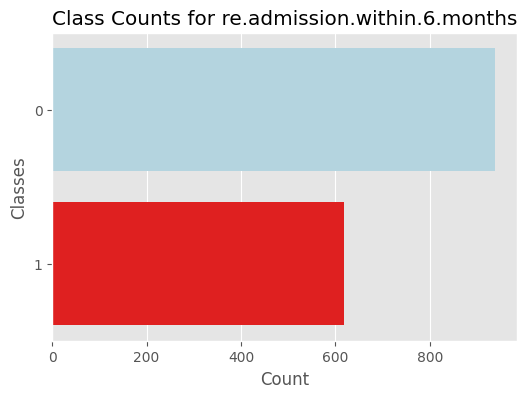

,Unnamed: 0,inpatient.number,DestinationDischarge,admission.ward,admission.way,occupation,discharge.department,visit.times,gender,body.temperature,...,oxygen.saturation,partial.oxygen.pressure,oxyhemoglobin,anion.gap,free.calcium,total.hemoglobin,GCS,dischargeDay,ageCat,re.admission.within.6.months
0,1702,772931,Unknown,Cardiology,Emergency,UrbanResident,Cardiology,1,Male,37.7,...,NaN,NaN,NaN,NaN,NaN,NaN,15,8,"(69,79]",0
1,1149,807688,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Female,36.4,...,98.0,115.0,97.6,14.7,1.10,105.0,15,4,"(49,59]",0
2,596,761208,Home,Cardiology,NonEmergency,Others,Cardiology,1,Female,36.2,...,97.0,98.0,96.8,14.5,1.16,130.0,15,8,"(69,79]",1
3,160,739419,Home,Cardiology,Emergency,UrbanResident,Cardiology,1,Female,36.5,...,NaN,NaN,NaN,NaN,NaN,NaN,15,7,"(79,89]",1
4,1272,760934,Home,Cardiology,NonEmergency,UrbanResident,Cardiology,1,Male,36.8,...,NaN,NaN,NaN,NaN,NaN,NaN,15,11,"(69,79]",0


In [6]:
x = train.copy()
y = train['re.admission.within.6.months']

# Plot class counts
%matplotlib inline
plot_class_counts(x, 're.admission.within.6.months')

#Check Dataframe
x.head()

In [73]:
# Split into numerical and categorical variables based on dtypes
numerical_df = x.select_dtypes(include=['int64', 'float64'])  # Numerical features
categorical_df = x.select_dtypes(include=['object'])  # Categorical features

# Print numerical variables in a readable format
print("Numerical Variables:")
print("\n".join(numerical_df.columns))

# Print categorical variables in a readable format
print("Categorical Variables:")
print("\n".join(categorical_df.columns))

Numerical Variables:
Unnamed: 0
inpatient.number
visit.times
body.temperature
pulse
respiration
systolic.blood.pressure
diastolic.blood.pressure
map
weight
height
BMI
myocardial.infarction
congestive.heart.failure
peripheral.vascular.disease
cerebrovascular.disease
dementia
Chronic.obstructive.pulmonary.disease
connective.tissue.disease
peptic.ulcer.disease
diabetes
moderate.to.severe.chronic.kidney.disease
hemiplegia
leukemia
malignant.lymphoma
solid.tumor
liver.disease
AIDS
CCI.score
eye.opening
verbal.response
movement
fio2
acute.renal.failure
LVEF
left.ventricular.end.diastolic.diameter.LV
mitral.valve.EMS
mitral.valve.AMS
EA
tricuspid.valve.return.velocity
tricuspid.valve.return.pressure
creatinine.enzymatic.method
urea
uric.acid
glomerular.filtration.rate
cystatin
white.blood.cell
monocyte.ratio
monocyte.count
red.blood.cell
coefficient.of.variation.of.red.blood.cell.distribution.width
standard.deviation.of.red.blood.cell.distribution.width
mean.corpuscular.volume
hematocrit
lymp

## Categorical Features

In [76]:
# Check for nan and analyse the categories for each feature
analyze_categorical_features(categorical_df)

# Remove 'respiratory.support.' since it contains most of nan
df_cat = categorical_df.copy()
df_cat.drop('respiratory.support.', axis=1, inplace=True)

Categorical Feature Analysis

Missing Values:
                      Count  Percentage
occupation               22    1.413882
respiratory.support.   1528   98.200514

Value Counts:
DestinationDischarge
Home                  1059
HealthcareFacility     342
Unknown                155
Name: count, dtype: int64
Total Unique Values: 3
----------------------------------------
admission.ward
Cardiology     1199
GeneralWard     206
Others          139
ICU              12
Name: count, dtype: int64
Total Unique Values: 4
----------------------------------------
admission.way
NonEmergency    821
Emergency       735
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
occupation
UrbanResident    1289
farmer            155
Others             71
worker             12
Officer             7
Name: count, dtype: int64
Total Unique Values: 5
----------------------------------------
discharge.department
Cardiology     1324
GeneralWard     192
Others           36
ICU   

- The variable 'DestinationDischarge' contains a category 'Unknown': the idea is to set it to NaN and impute it,as will be shown later in the code. 
- The features 'NYHA.cardiac.function.classification', 'Killip.grade', 'ageCat' are categorical features but are characterized by an intrinsic order which must be kept. 
Therefore, they will be encoded using an Ordinal Encoder. 

In [87]:
%matplotlib qt

plot_distributions(df_cat, y, 're.admission.within.6.months')

From this representation, it is clear that some variables are not at all discriminative (there is not such different regarding the variable to predict within a category). The following features were dropped:
- 'admission.way', 
- 'discharge.department', 
- 'type.II.respiratory.failure', 
- 'consciousness',
- 'oxygen.inhalation', 

In [92]:
df_cat_final = process_cat_variables(df_cat)

plot_distributions(df_cat_final, y, 're.admission.within.6.months')


#### Binary variables

In [48]:
# Binary variables as categorical
binary_variables= ['myocardial.infarction','congestive.heart.failure','peripheral.vascular.disease','cerebrovascular.disease',
                   'dementia','Chronic.obstructive.pulmonary.disease','connective.tissue.disease','peptic.ulcer.disease',
                   'diabetes','moderate.to.severe.chronic.kidney.disease','hemiplegia','leukemia','malignant.lymphoma',
                   'solid.tumor','liver.disease','AIDS','acute.renal.failure']

# Add binary variables to the categorical dataframe                   
df_binary = numerical_df[binary_variables]

# Drop binary variables from the numerical dataframe
df_numerical = numerical_df.drop(labels=binary_variables, axis=1, inplace=False)

df_binary

,myocardial.infarction,congestive.heart.failure,peripheral.vascular.disease,cerebrovascular.disease,dementia,Chronic.obstructive.pulmonary.disease,connective.tissue.disease,peptic.ulcer.disease,diabetes,moderate.to.severe.chronic.kidney.disease,hemiplegia,leukemia,malignant.lymphoma,solid.tumor,liver.disease,AIDS,acute.renal.failure
0,0,1,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0
1,0,1,0,0,0,0,1,0.0,0,0.0,0,0,0,0,0.0,0,0
2,0,1,0,0,1,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0
3,0,0,0,1,0,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0
4,0,1,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,0,1,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0
1552,0,1,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0
1553,0,1,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0
1554,0,1,0,1,0,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0


In [82]:
analyze_categorical_features(df_binary)
plot_distributions(df_binary, y, 're.admission.within.6.months')
# plot_binary_distributions(df_binary, y, 're.admission.within.6.months')

Categorical Feature Analysis

Missing Values:
                                           Count  Percentage
peptic.ulcer.disease                           1    0.064267
moderate.to.severe.chronic.kidney.disease      2    0.128535
liver.disease                                  1    0.064267

Value Counts:
myocardial.infarction
0    1447
1     109
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
congestive.heart.failure
1    1458
0      98
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
peripheral.vascular.disease
0    1480
1      76
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
cerebrovascular.disease
0    1444
1     112
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
dementia
0    1470
1      86
Name: count, dtype: int64
Total Unique Values: 2
----------------------------------------
Chronic.obstructive.pulmonary.disease

the distributions are highly imbalanced, with very few cases having the disease (1). This makes individual binary variables less informative on their own.
A good approach would be to combine these binary variables into a new aggregated variable representing the presence of any severe disease or a related condition.

In [91]:
df_binary_new_var = process_binary_variables(df_binary)

plot_distributions(df_binary_new_var, y, 're.admission.within.6.months')

var_to_drop = ['myocardial.infarction','peripheral.vascular.disease','cerebrovascular.disease',
               'AIDS','acute.renal.failure','hemiplegia','leukemia','malignant.lymphoma','solid.tumor','liver.disease','connective.tissue.disease','peptic.ulcer.disease','dementia',
                'Chronic.obstructive.pulmonary.disease', 'cancer', 'chronic_heart_pulmonary_disease']
df_bin_final = df_binary_new_var.drop(var_to_drop, axis=1)

plot_distributions(df_bin_final, y, 're.admission.within.6.months')

## Analyse Ordinal variables

In [90]:
ordinal_features=['visit.times','CCI.score','eye.opening','verbal.response','movement','GCS']

df_ordinal = df_numerical[ordinal_features]

plot_distributions(df_ordinal, y, 're.admission.within.6.months')

# keep only 'CCI.score' and as a numerical, the others do not seem relevant
df_num = df_numerical.drop(labels=['visit.times','eye.opening','verbal.response','movement','GCS'], axis=1)
df_num

,Unnamed: 0,inpatient.number,body.temperature,pulse,respiration,systolic.blood.pressure,diastolic.blood.pressure,map,weight,height,...,carboxyhemoglobin,body.temperature.blood.gas,oxygen.saturation,partial.oxygen.pressure,oxyhemoglobin,anion.gap,free.calcium,total.hemoglobin,dischargeDay,re.admission.within.6.months
0,1702,772931,37.7,106,19,105,60,75.000000,46.0,1.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,0
1,1149,807688,36.4,85,19,124,64,84.000000,55.0,1.60,...,0.1,37.0,98.0,115.0,97.6,14.7,1.10,105.0,4,0
2,596,761208,36.2,92,19,146,82,103.333333,53.0,1.50,...,0.3,37.0,97.0,98.0,96.8,14.5,1.16,130.0,8,1
3,160,739419,36.5,72,20,160,90,113.333333,40.0,1.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,1
4,1272,760934,36.8,106,21,120,80,93.333333,59.0,1.60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,1842,807802,36.4,78,19,144,90,108.000000,66.0,1.58,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,0
1552,696,738780,36.3,104,19,136,62,86.666667,48.0,1.56,...,0.9,37.0,97.0,90.0,96.0,20.2,1.00,165.0,5,1
1553,1672,831820,36.4,80,17,106,64,78.000000,49.0,1.60,...,1.0,37.0,99.0,161.0,97.1,15.4,1.07,83.0,10,1
1554,707,843341,36.2,63,18,120,86,97.333333,49.0,1.45,...,0.1,37.0,98.0,125.0,98.1,17.1,1.16,134.0,8,0


## Numerical Features

In [79]:
check_nan_columns(df_num, threshold=0.3)

# Feature engineering: create variable "exam" and add it to the binary dataframe
df_bin_final = create_exam_feature(df_num, df_bin_final)

df_num_processed = df_num.drop(['Unnamed: 0','inpatient.number'], axis=1)

df_num_no_nan = drop_high_nan_columns(df_num_processed, threshold=0.3)

How many columns with %NaN > 30.0%? 41
left.ventricular.end.diastolic.diameter.LV: 34.51%
reduced.hemoglobin: 50.58%
measured.residual.base: 50.58%
lactate: 50.58%
chloride.ion: 50.58%
potassium.ion: 50.58%
glucose.blood.gas: 50.58%
sodium.ion: 50.58%
hematocrit.blood.gas: 50.58%
partial.pressure.of.carbon.dioxide: 50.58%
methemoglobin: 50.58%
total.carbon.dioxide: 50.58%
standard.bicarbonate: 50.58%
standard.residual.base: 50.58%
pH: 50.58%
measured.bicarbonate: 50.58%
free.calcium: 50.58%
anion.gap: 50.58%
oxyhemoglobin: 50.58%
partial.oxygen.pressure: 50.58%
oxygen.saturation: 50.58%
body.temperature.blood.gas: 50.58%
carboxyhemoglobin: 50.58%
total.hemoglobin: 50.58%
mitral.valve.EMS: 51.09%
high.sensitivity.protein: 52.89%
tricuspid.valve.return.velocity: 60.03%
LVEF: 67.54%
glutamic.oxaliplatin: 70.44%
mitral.valve.AMS: 73.46%
Inorganic.Phosphorus: 79.95%
serum.magnesium: 79.95%
EA: 80.59%
myoglobin: 80.78%
erythrocyte.sedimentation.rate: 85.15%
lipoprotein: 91.45%
apolipoprotein

From this analysis, it is evident that certain variables, such as chloride.ion, sodium.ion, glucose.blood.gas, and others, exhibit identical patterns in the number of missing values. This suggests that a subset of individuals underwent specific medical tests, while others did not.

We hypothesize that additional exams were given to gather more diagnostic information, possibly due to insufficient data during the initial visit, which could influence the likelihood of readmission. Based on this assumption, we created a new binary variable, exam, which is set to 1 for individuals who received at least one of these tests and 0 for those who did not.

The original features used to create the exam variable will be dropped in the section dedicated to handling missing values, as they are no longer required for subsequent analysis.

In [80]:
# Check the distribution of numerical variables
plot_num_var_histograms(df_num_no_nan)

# plot_pairplot(df_num_no_nan, max_features=15)
# only 'glomerular.filtration.rate' seems to be discrimninative

#### Outliers analysis

In [54]:
# %matplotlib inline
# To investigate the presence of outliers, we can also plot the boxplots of these variables:
columns = ['BMI', 'total.bile.acid', 'standard.deviation.of.red.blood.cell.distribution.width']
plot_boxplots(df_num_no_nan, columns)

In [55]:
df_zscored = analyze_outliers(df_num_no_nan)

Train subjects before outlier removal: (1556, 78)


Clearly, not all these values are really outliers: indeed, dealing with pathological conditions, many of these values are due to pathology itself. 
In particular, analyzing each of these features, only the following cases were found to be outliers, probably due to wrong entries:
-  'systolic.blood.pressure', 'diastolic.blood.pressure', 'map' = 0 values. 
- 'weight' = 0, 
- 'height' = 0.35cm
- 'BMI' = 404 


These were converted in NaN values. To do this, we define a class which we will then be able to use in the final Pipeline: this class will convert these specific conditions into NaN and will, in the end, drop the features characterized by a percentage of NaN values > 40%.

In [58]:
# Create an instance of the transformer
outlier_transformer = OutlierToNan(move_outliers=True, nan_threshold=0.4)

# Apply it to a DataFrame
df_num_outlier  = outlier_transformer.transform(df_num_no_nan)

#### NaN values analysis

As already said, features with a percentage of nan > 30% were simply removed from the dataset, since the imputation would have been biased and deleting the rows would have reduced the sample size too much. 

For the remaining variables, different possibilities were investigated, namely:
- Simple Imputation with mean
- Simple Imputation with median
- Iterative Imputation (MICE) considering a different number of nearest features (10,12,15). 

The following lines of code will show this analysis, which follows these steps:
1) Split the training fold into numerical and categorical variables, as shown above. 
3) Apply different imputation methods and verify which brings to a better f1 score.

In [ ]:
import numpy as np
import pandas as pd

# df_num_outlier
# df_bin_final
# df_cat_final


In [61]:
from sklearn.ensemble import RandomForestClassifier
from src.process import evaluate_imputation_methods
from src.visualisation import plot_imputation_results
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier


y = df_num_outlier['re.admission.within.6.months']  
df_num_cleaned = df_num_outlier.drop(columns=['re.admission.within.6.months'])

logreg_model = make_pipeline(
    StandardScaler(),  # Ensure the features are scaled
    LogisticRegression(solver='lbfgs', max_iter=1000, random_state=0)  # Increase max_iter
)

gb_model = GradientBoostingClassifier(random_state=0)
rf_model = RandomForestClassifier(random_state=0)

# Call the function with Random Forest
scores = evaluate_imputation_methods(df_num_cleaned, y, rf_model)

plot_imputation_results(scores)
print(scores)

  SimpleImputer           IterativeImputer                    
           mean    median               10        12        15
0      0.325260  0.369128         0.343234  0.372881  0.279570
1      0.389776  0.381538         0.406250  0.389058  0.391167
2      0.376712  0.325088         0.376307  0.327402  0.326241


In the end, the Simple Imputer with the mean is enough, since the other results have more variability and the improvement is not significant.

In [62]:
# Apply SimpleImputer to handle missing values
imputer = SimpleImputer(strategy='mean')  # You can change 'mean' to 'median' or 'most_frequent'
df_num_imputed = pd.DataFrame(
    imputer.fit_transform(df_num_cleaned), 
    columns=df_num_cleaned.columns
)

# Check the result
print(f"Missing values remaining: {df_num_imputed.isna().sum().sum()}")


Missing values remaining: 0


## Dimensionality Reduction 

### PCA: Principal Component Analysis

In [64]:
df_pc = apply_pca(df_num_imputed, plot_exp_variance=True, plot_feat_importance=True)

Number of components needed to reach 95% variance: 46


- No dominant components: The first principal component explains only 8% of variance, and the cumulative variance grows gradually, indicating no single feature strongly dominates.
- Dimensionality reduction possible: Keeping 40 components captures 90% of the variance, while 46 components reach 95%, reducing complexity while retaining information.
- Highly distributed variance: The dataset has a spread-out variance structure, suggesting that PCA alone may not fully capture key patterns, and alternative techniques like feature selection or non-linear embeddings could be explored.

### Sequential Feature Selection 

In [69]:
import xgboost as xgb
from packaging import version

xgb_version = version.parse(xgb.__version__)
gpu_kwargs = {"device": "cuda"} if xgb_version >= version.parse("2.0.0") else {"tree_method": "gpu_hist"}

# Initialize the estimator
estimator = RandomForestClassifier(random_state=0, n_jobs=-1)
# estimator = xgb.XGBClassifier(
#     n_estimators=100,
#     max_depth=6,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     learning_rate=0.1,
#     eval_metric="logloss",
#     **gpu_kwargs
# )

# Initialize the FeatureSelector
selector = FeatureSelector(estimator=estimator, n_features=10, corr_threshold=0.85, scoring='accuracy', cv=3)

# Perform feature selection
X_reduced, selected_features = selector.fit(dataset=df_num_imputed, labels=y, corr_based=False, method='SBS')

# Results
print(f"Selected features: {selected_features}")
print(f"Reduced dataset shape: {X_reduced.shape}")


Performing sequential feature selection...
Sequential Feature Selection reduced features to 10.
Selected features: ['uric.acid', 'glomerular.filtration.rate', 'red.blood.cell', 'lymphocyte.count', 'eosinophil.count', 'neutrophil.count', 'activated.partial.thromboplastin.time', 'potassium', 'globulin', 'dischargeDay']
Reduced dataset shape: (1556, 10)
